In [1]:
from catboost import Pool
import pandas
from sklearn.model_selection import train_test_split

data = pandas.read_csv('false_and_true_data.csv', sep=';')

train_X = data['messages']
train_y = data['labels']

train_X, eval_X, train_y, eval_y = train_test_split(train_X, train_y, test_size=0.2, random_state=10)

text_features = [0]

import semantic
lemma_train_X = []
for text in train_X:
    lemma_text = semantic.lemmatize(str(text))
    lemma_train_X.append(lemma_text)

lemma_eval_X = []
for text in eval_X:
    lemma_text = semantic.lemmatize(str(text))
    lemma_eval_X.append(lemma_text)

train_pool = Pool(data=lemma_train_X,
                    label=train_y,
                    text_features=text_features)

eval_pool = Pool(data=lemma_eval_X, label=eval_y, text_features=text_features)

pandas.DataFrame(lemma_train_X)

[nltk_data] Downloading package stopwords to C:\Users\danii.LAPTOP-
[nltk_data]     VHVGL7JM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,0
0,в мессенджер среди житель российский регион ра...
1,группа хакер anonymous заявить соцсеть успешно...
2,ранее сообщаться экипаж эвакуировать находитьс...
3,о полный уничтожение 37 ой отдельный мотострел...
4,в вс м бреда больной сознание украинский пропа...
...,...
1551,от имя протоиерей смоленский собор белгород не...
1552,ряд сми сообщить ozon сократить часть сотрудни...
1553,этот факт отрицать сам практиковать стоматолог...
1554,всу сбить российский самолёт о писать официаль...


In [2]:
from catboost import CatBoostClassifier

options = {
            "tokenizers" : [{
                "tokenizer_id" : "Sense",
                "separator_type" : "BySense",
                'lowercasing': 'True',
                'token_types':['Word', 'Number']
            }],

            "dictionaries" : [{
                "dictionary_id" : "BiGram",
                "max_dictionary_size" : "50000",
                "gram_order" : "2"
            }, {
                "dictionary_id" : "Word",
                "max_dictionary_size" : "50000",
                "gram_order" : "1"
            }],

            "feature_processing" : {
                "default" : [{
                    "dictionaries_names" : ["Word", "BiGram"],
                    "feature_calcers" : ["BoW:top_tokens_count=1000", "NaiveBayes"],
                    "tokenizers_names" : ["Sense"]
                },
                {
                    "dictionaries_names" : ["Word"],
                    "feature_calcers" : ["NaiveBayes"],
                    "tokenizers_names" : ["Sense"]
                },
                {
                    "dictionaries_names" : ["Word", "BiGram"],
                    "feature_calcers" : ["BM25"],
                    "tokenizers_names" : ["Sense"]
                }]
            }
        }

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=1000,
                            task_type="GPU",
                            devices='0:1',
                            loss_function='CrossEntropy',
                            eval_metric='AUC',
                            custom_loss=['Accuracy'],
                            random_strength=5,
                            random_seed=1,
                            text_processing=options)

model.fit(train_pool, eval_set=eval_pool, use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8857344	test: 0.8853224	best: 0.8853224 (0)	total: 52.9ms	remaining: 52.8s
1:	learn: 0.9278990	test: 0.9432332	best: 0.9432332 (1)	total: 99.9ms	remaining: 49.9s
2:	learn: 0.9350560	test: 0.9496502	best: 0.9496502 (2)	total: 144ms	remaining: 48s
3:	learn: 0.9578057	test: 0.9594730	best: 0.9594730 (3)	total: 190ms	remaining: 47.3s
4:	learn: 0.9677795	test: 0.9745292	best: 0.9745292 (4)	total: 236ms	remaining: 47s
5:	learn: 0.9690773	test: 0.9795130	best: 0.9795130 (5)	total: 281ms	remaining: 46.6s
6:	learn: 0.9744971	test: 0.9791711	best: 0.9795130 (5)	total: 328ms	remaining: 46.5s
7:	learn: 0.9763243	test: 0.9822480	best: 0.9822480 (7)	total: 373ms	remaining: 46.2s
8:	learn: 0.9768117	test: 0.9815774	best: 0.9822480 (7)	total: 414ms	remaining: 45.6s
9:	learn: 0.9773420	test: 0.9817221	best: 0.9822480 (7)	total: 454ms	remaining: 44.9s
10:	learn: 0.9770017	test: 0.9819982	best: 0.9822480 (7)	total: 494ms	remaining: 44.4s
11:	learn: 0.9785951	test: 0.9832211	best: 0.9832211 (1

In [3]:
model.tree_count_

756

In [ ]:
model.plot_tree(tree_idx=1, pool=train_pool)

In [4]:
model.save_model('antifake.model')

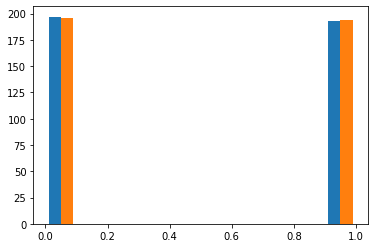

In [5]:
pred_y = model.predict(eval_pool)

import matplotlib.pyplot as plt
plt.hist([pred_y, eval_y])
plt.show()

In [6]:
from sklearn.metrics import classification_report
print(classification_report(pred_y, eval_y))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       197
           1       0.95      0.96      0.96       193

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



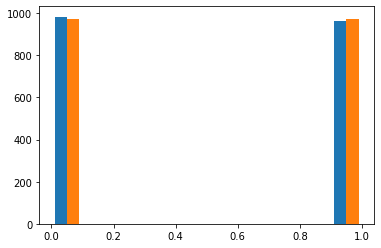

In [7]:
lemma_ter_X = []
for ter_text in data['messages']:
    lemma_ter_X.append(semantic.lemmatize(ter_text))

ter_pool = Pool(data=lemma_ter_X, text_features=text_features)
pred_y = model.predict(ter_pool)

import matplotlib.pyplot as plt
plt.hist([pred_y, data['labels']])
plt.show()

In [8]:
a = []
for i in range(len(pred_y)):
    if pred_y[i] == 0: a.append(data['messages'][i])

print(len(a), '\n', '\n'.join(a))

983 
  Власти опровергли появившуюся в соцсети информацию, что жителям двух приграничных районов Воронежской области месяц работы будет считаться за два. 
"В россошанском паблике во "Вконтакте" появилась информация о том, что жителям (приграничных) Кантемировского и Россошанского районов один месяц работы будет считаться за два, будет единовременная выплата и компенсация в случае ранения или смерти. Такая мера введена только для работников компании "Россети", - сообщает в субботу администрация Россошанского района в своем Telegram-канале. 
Как отмечают власти, соответствующий приказ подписал генеральный директор ПАО "Россети Центр" Игорь Маковский, и это связано с "повышенным уровнем опасности" работников организации.
 Агент Ромелу Лукаку опровёрг эти слухи.
«Много шума из ничего», — сказал он в интервью La Repubblica, когда его спросили о связях бельгийца с миланским клубом.

Однако, он добавил, что Лукаку недоволен количеством игрового времени, которое ему предоставляет главный трене

In [9]:
lem_text = semantic.lemmatize(input('Enter message: '))
print(lem_text)
input_pool = Pool([lem_text], text_features=text_features)
        
print(model.predict(input_pool))
print(model.predict_proba(input_pool))

CatBoostError: Input data must have at least one feature

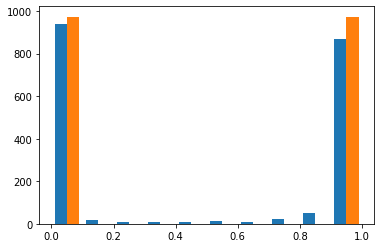

In [10]:
lemma_ter_X = []
for ter_text in data['messages']:
    lemma_ter_X.append(semantic.lemmatize(ter_text))

ter_pool = Pool(data=lemma_ter_X, text_features=text_features)
pred_y = model.predict_proba(ter_pool)

chance_y = []
for p in pred_y:
    chance_y.append(p[1])

import matplotlib.pyplot as plt
plt.hist([chance_y, data['labels']])
plt.show()

In [ ]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 200
params['custom_loss'] = 'AUC'
params['random_seed'] = 40
params['learning_rate'] = 0.7

cv_data = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))